In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import scipy.sparse as sparse
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from tqdm import tqdm

from catboost import CatBoostClassifier
from pandas_profiling import ProfileReport

%matplotlib inline

/Users/maksim/opt/anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


## Data loading

In [2]:
train = pd.read_csv('train.csv', low_memory=False)
test = pd.read_csv('test.csv', low_memory=False)
submission = pd.read_csv('sample_submission.csv', low_memory=False)

In [3]:
train_data, test_data = train_test_split(train, test_size=0.2, shuffle=True, random_state=42)

In [4]:
# train_data = train
# test_data = test

## Simple features-free modeling with LightFM

In [5]:
ratings_coo = sparse.coo_matrix((train_data.rating.astype(int), 
                                 (train_data.userid, train_data.itemid)))

In [6]:
# lr_list = [0.11, 0.12, 0.13, 0.15, 0.17, 0.2, 0.25, 0.3]
# comp_list = [10, 15, 20, 25, 30, 50, 100, 150, 300]

lr_list = [0.17]
comp_list = [105, 150, 200]

score_list = []
params = []

In [7]:
for lr in tqdm(lr_list):
    for comp in comp_list:
        for ep in [10, 11]:
            model = LightFM(learning_rate=lr, loss='logistic', no_components=comp, 
                            learning_schedule='adagrad', random_state=42)
            model = model.fit(ratings_coo, epochs=ep, num_threads=8)
            preds = model.predict(test_data.userid.values, test_data.itemid.values)
            preds_norm = ((preds-preds.min()) / (preds-preds.min()).max())
            roc_auc = roc_auc_score(test_data.rating.values, preds_norm)
            params.append([lr, comp])
            score_list.append(roc_auc)
            print(f'epochs = {ep}')
            print(f'lr = {lr}, comp = {comp}')
            print(f'roc_auc_score = {roc_auc}')
            print('######################################################')
        
max_idx = np.argmax(np.array(score_list))
print()
print(f'epoch = {ep}')
print(score_list[max_idx])
print(params[max_idx])

  0%|          | 0/1 [00:00<?, ?it/s]

epochs = 10
lr = 0.17, comp = 105
roc_auc_score = 0.7595045154621247
######################################################
epochs = 11
lr = 0.17, comp = 105
roc_auc_score = 0.7589434460034084
######################################################
epochs = 10
lr = 0.17, comp = 150
roc_auc_score = 0.7596613539035579
######################################################
epochs = 11
lr = 0.17, comp = 150
roc_auc_score = 0.7593544627248463
######################################################
epochs = 10
lr = 0.17, comp = 200
roc_auc_score = 0.7595644850620639
######################################################


100%|██████████| 1/1 [02:55<00:00, 175.41s/it]

epochs = 11
lr = 0.17, comp = 200
roc_auc_score = 0.7591781405139923
######################################################

epoch = 11
0.7596613539035579
[0.17, 150]


## Catsboost classifier as recommender

### Data analysis and cleaning

In [8]:
with open('meta_Grocery_and_Gourmet_Food.json', 'rb') as file:
    meta_list = []
    for line in file.readlines():
        meta_list.append(json.loads(line))

In [9]:
meta = pd.DataFrame(meta_list)

In [10]:
train_full = pd.merge(train, meta, on='asin')

In [11]:
columns_to_drop = [
    'reviewTime',
    'reviewerName',
    'style',
    'image_x',
    'image_y',
    'date',
    'feature',
    'details',
    'tech1',
    'fit', 
    'similar_item', 
    'vote']

In [15]:
def clean_data(input_data):
    data = input_data.drop(columns_to_drop, axis=1)
    
    data.summary.fillna('Nothing', inplace=True)
    data.brand.fillna('No brand', inplace=True)
    data.description.fillna('No description', inplace=True)
    data['reviewText'].fillna('No review', inplace=True)
    data['main_cat'].fillna(data.main_cat.mode()[0], inplace=True)
    
    # from list of categoryies to additional columns
    cat_df = pd.DataFrame(data.category.values.tolist(), 
                          index=data.index, dtype=str).add_prefix('category_')
    cat_df.fillna('No category', inplace=True)
    data = pd.concat([data, cat_df.iloc[:, :4]], axis=1)
    
    # join all descriptions in the list
    data['description'] = data.description.map(lambda x: ' '.join(x))
    
    # fix the price
    data['price'] = data.price.str.findall(r'\d+\.\d+').apply(lambda x: 
                                                              x if type(x)!=list else x[0]).astype('float64')
    data['price'].fillna(data.price.mean(), inplace=True)
    data['price'] = np.log(data['price']+1)
    
    # also_view/buy features - put the count of viewed/bought items
    data['also_view'] = data.also_view.apply(lambda x: np.nan if type(x)!=list else len(x))
    data['also_buy'] = data.also_buy.apply(lambda x: np.nan if type(x)!=list else len(x))
    data['also_view'].fillna(data['also_view'].median(), inplace=True)
    data['also_buy'].fillna(data['also_buy'].median(), inplace=True)
#     data['also_view'] = np.log(data['also_view']+1)
#     data['also_buy'] = np.log(data['also_buy']+1)
    
    # verified
    data['verified'] = data.verified.map({True:1, False:0})
    
    # rank
    data['rank'] = data['rank'].str.findall('\d+,+\d+').map(lambda x: float(x[0].replace(',', '.')) 
                                                            if ((type(x)==list)
                                                            and (len(x)!=0)) else np.nan)
    data['rank'].fillna(data['rank'].mean(), inplace=True)
    data['rank'] = np.log(data['rank']+1)
    
    # log overall
#     data['overall'] = np.log(data['overall']+1)
    
    # delete bad features and target
    data.drop('category', axis=1, inplace=True)
    data.drop('category_0', axis=1, inplace=True)
    
    return data

In [16]:
sample = train_full.sample(frac=1)

In [17]:
data_sample = clean_data(sample)

In [18]:
profile = ProfileReport(df=data_sample, title='EDA')

In [19]:
profile.to_notebook_iframe()

### Data splitting

In [20]:
num_features = ['unixReviewTime', 'price', 'rank', 'also_view', 'also_buy',]
cat_features = ['verified', 'asin', 'userid', 'itemid', 'brand', 'main_cat', 
                'category_1', 'category_2', 'category_3']
text_features = ['reviewText', 'summary', 'title',]# 'description']

target_features = ['overall', 'rating']

In [21]:
X, y = data_sample.drop(target_features, axis=1), data_sample.rating

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, shuffle=True, random_state=42)

### Custom "mean" encoding

In [23]:
def make_rating_mean_count(df_mean_train, df_mean_test, col, df_train, df_test, group_cols=None):
    
    # функция добавляет в df_mean_train и df_mean_test столбцы средней цены/количества объявлений
    # для каждого категориального признака col. group_cols - лист с дополнительными признаками,
    # которые позволяют группировать рейтинг/количества по связке "признаки group_cols + признак col"
    
    join_cols = []
    
    if (group_cols!=None) and (col not in group_cols):
        join_cols.append(col) 
        join_cols += group_cols
    else:
        join_cols.append(col)
    df_mean_train[col+'_rating_mean'] = df_train[join_cols].merge(df_train.groupby(by=join_cols, as_index=False).
                                                                 rating.median(), on=join_cols, how='left').iloc[:,-1]
    df_mean_test[col+'_rating_mean'] = df_test[join_cols].merge(df_train.groupby(by=join_cols, as_index=False).
                                                               rating.median(), on=join_cols, how='left').iloc[:,-1]
    df_mean_train[col+'_count'] = df_train[join_cols].merge(df_train.groupby(by=join_cols, as_index=False).
                                                            rating.count(), on=join_cols, how='left').iloc[:,-1]
    df_mean_test[col+'_count'] = df_test[join_cols].merge(df_train.groupby(by=join_cols, as_index=False).
                                                          rating.count(), on=join_cols, how='left').iloc[:,-1]   
    
    if col == 'model': 
        df_mean_test[col+'_rating_mean'] = df_mean_test[col+'_rating_mean'].\
        fillna(df_mean_test['brand_rating_mean']) 
        
        df_mean_test[col+'_count'] = df_mean_test[col+'_count'].\
        fillna(df_mean_test['brand_count'])
    
    if col == 'model_name':
        df_mean_test[col+'_rating_mean'] = df_mean_test[col+'_rating_mean'].\
        fillna(df_mean_test['model_rating_mean']).\
        fillna(df_mean_test['brand_rating_mean'])    
        
        df_mean_test[col+'_count'] = df_mean_test[col+'_count'].\
        fillna(df_mean_test['model_count']).\
        fillna(df_mean_test['brand_count'])  
    
    if col == 'modification':
        df_mean_test[col+'_rating_mean'] = df_mean_test[col+'_rating_mean'].\
        fillna(df_mean_test['model_name_rating_mean']).fillna(df_mean_test['model_rating_mean']).\
        fillna(df_mean_test['brand_rating_mean'])    
        
        df_mean_test[col+'_count'] = df_mean_test[col+'_count'].\
        fillna(df_mean_test['model_name_count']).fillna(df_mean_test['model_count']).\
        fillna(df_mean_test['brand_count'])
        
        
    other_filler_rating_mean = df_mean_test[f'{col}_rating_mean'].median()
    df_mean_test[f'{col}_rating_mean'] = df_mean_test[f'{col}_rating_mean'].fillna(other_filler_rating_mean)

    other_filler_count = df_mean_test[f'{col}_count'].median()
    df_mean_test[f'{col}_count'] = df_mean_test[f'{col}_count'].fillna(other_filler_count)



def make_num_feat_mean(df_mean_train, df_mean_test, col, num_col, df_train, df_test, group_cols=None):
    
    # аналогичная функция, но кодирует категориальные признаки по средним значениям числовых колонок (num_features)
    
    if col in ['itemid', 'userid']:
        join_cols = []

        if (group_cols!=None) and (col not in group_cols):
            join_cols.append(col) 
            join_cols += group_cols
        else:
            join_cols.append(col)

        df_mean_train[f'{col}_{num_col}_mean'] = df_train[join_cols].merge(df_train.groupby(by=join_cols, as_index=False)\
                                                               [num_col].mean(), on=join_cols, how='left').iloc[:,-1]

        df_mean_test[f'{col}_{num_col}_mean'] = df_test[join_cols].merge(df_train.groupby(by=join_cols, as_index=False)\
                                                               [num_col].mean(), on=join_cols, how='left').iloc[:,-1]

        if col == 'model': 
            df_mean_test[f'{col}_{num_col}_mean'] = df_mean_test[f'{col}_{num_col}_mean'].\
            fillna(df_mean_test[f'brand_{num_col}_mean']) 

        if col == 'model_name':
            df_mean_test[f'{col}_{num_col}_mean'] = df_mean_test[f'{col}_{num_col}_mean'].\
            fillna(df_mean_test[f'model_{num_col}_mean']).\
            fillna(df_mean_test[f'brand_{num_col}_mean'])    

        if col == 'modification':
            df_mean_test[f'{col}_{num_col}_mean'] = df_mean_test[f'{col}_{num_col}_mean'].\
            fillna(df_mean_test[f'model_name_{num_col}_mean']).fillna(df_mean_test[f'model_{num_col}_mean']).\
            fillna(df_mean_test[f'brand_{num_col}_mean'])    

        other_filler = df_mean_test[f'{col}_{num_col}_mean'].median()
        df_mean_test[f'{col}_{num_col}_mean'] = df_mean_test[f'{col}_{num_col}_mean'].fillna(other_filler)



In [24]:
# получаем индексы train и test выборок
train_idx = y_train.index.values
test_idx = y_test.index.values

# добавляем таргет и получаем 2 выборки "признак=таргет"
df_train = data_sample.loc[train_idx]
df_test = data_sample.loc[test_idx]

# пустые фреймы для mean/count encoding features
df_mean_train = pd.DataFrame(index=train_idx)
df_mean_test = pd.DataFrame(index=test_idx)

# создаем кодированные категориальные признаки
for col in cat_features:
    make_rating_mean_count(df_mean_train, df_mean_test, col, df_train, df_test, group_cols=None)
    for num_col in num_features:
        make_num_feat_mean(df_mean_train, df_mean_test, col, num_col, df_train, df_test, group_cols=None)
        
mean_columns = df_mean_test.columns

X_train_cat = np.array(df_mean_train)
X_test_cat = np.array(df_mean_test)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

### Vectorizing text features

In [25]:
vectorizer = TfidfVectorizer(stop_words='english', analyzer='word')

In [26]:
i = 0
for col in text_features:
    if i==0:
        X_train_text = vectorizer.fit_transform(X_train[col])
        X_test_text = vectorizer.transform(X_test[col])
        text_fi_cols = vectorizer.get_feature_names()
        continue
    X_train_text = sparse.hstack([X_train_text, vectorizer.fit_transform(X_train[col])])
    X_test_text = sparse.hstack([X_test_text, vectorizer.transform(X_test[col])])
    text_fi_cols += vectorizer.get_feature_names()

In [27]:
# X_num_norm_train = normalize(X_train[num_features])

In [28]:
X_train_final = sparse.hstack([X_train[num_features], X_train_cat, X_train_text])
X_test_final = sparse.hstack([X_test[num_features], X_test_cat, X_test_text])

## Modelling with CatboostClassifier

In [29]:
estimator = CatBoostClassifier(depth=7, iterations=1000, learning_rate=0.1, verbose=False, random_state=42)

In [30]:
estimator.fit(X_train_final, y_train)

In [31]:
y_pred = estimator.predict_proba(X_test_final)

In [32]:
y_pred_1 = estimator.predict(X_test_final)

In [33]:
ras = roc_auc_score(y_test.values, y_pred[:,1])

In [34]:
ras

0.6352162885160675

In [35]:
f1_score(y_test.values, y_pred_1)

0.918505687300317

In [36]:
fpr, tpr, thresholds = roc_curve(y_test.values, y_pred[:,1])

<AxesSubplot:>

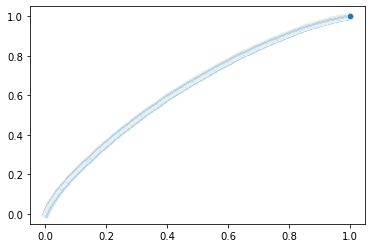

In [37]:
sns.scatterplot(x=fpr, y=tpr)

In [38]:
### Post-modelling analysis

In [39]:
# fi_cols = num_features + mean_columns.tolist() + text_fi_cols

In [40]:
# fi_df = pd.DataFrame(zip(estimator.feature_importances_, fi_cols), columns=['importance', 'name'])

In [41]:
# fi_df.sort_values(by='importance', ascending=False).head(50)

In [42]:
# rebuilt_data['sqerror'] = (rebuilt_data.rating - rebuilt_data.pred)**2

In [43]:
# cols = num_features + cat_features + text_features

In [44]:
# rebuilt_data.columns

In [45]:
# rebuilt_data.groupby(['main_cat']).sqerror.agg(['mean', 'count']).\
# sort_values(by=['mean'],ascending=False).head(50)

In [46]:
# f1_score(y_test.values, y_pred_1)

## LightFM with item/user features as recommender

### Prepare LightFM с item/user features

Using cleaned original features

In [47]:
features_user = X_train[['verified', 'userid', 'also_view', 'main_cat', 'also_buy']]
features_item = X_train[['itemid', 'brand', 'rank', 
                             'main_cat', 'price', 'category_1', 'category_2', 'category_3']]

df = pd.concat([X_train[['userid', 'itemid',]], y_train], axis=1)
df_test = pd.concat([X_test[['userid', 'itemid',]], y_test], axis=1)

Custom 'mean' encoded features (commented - too long modeling, more than 2 hours)

In [48]:
# features_user = pd.concat([df_mean_train[['verified_rating_mean', 'verified_count',
#                                          'userid_rating_mean', 'userid_count', 
#                                          'userid_unixReviewTime_mean', 'userid_price_mean', 
#                                          'userid_rank_mean', 
#                                          'userid_also_view_mean', 'userid_also_buy_mean']], 
#                            X_train['userid']], axis=1)

# features_item = pd.concat([df_mean_train[['asin_rating_mean', 'asin_count', 'itemid_rating_mean','itemid_count', 
#                                           'itemid_unixReviewTime_mean', 'itemid_price_mean', 
#                                           'itemid_rank_mean', 'itemid_also_view_mean',
#                                           'itemid_also_buy_mean']], 
#                            X_train['itemid']], axis=1)

# df = pd.concat([X_train[['userid', 'itemid']], y_train], axis=1)
# df_test = pd.concat([X_test[['userid', 'itemid']], y_test], axis=1)

Creating interaction matrix

In [49]:
item_f = []
col = []
unique_f1 = []
for column in features_item.drop(['itemid'], axis=1):
    col += [column]*len(features_item[column].unique())
    unique_f1 += list(features_item[column].unique())
for x,y in zip(col, unique_f1):
    res = str(x)+ ":" +str(y)
    item_f.append(res)
    
user_f = []
col = []
unique_f1 = []
for column in features_user.drop(['userid'], axis=1):
    col += [column]*len(features_user[column].unique())
    unique_f1 += list(features_user[column].unique())
for x,y in zip(col, unique_f1):
    res = str(x)+ ":" +str(y)
    user_f.append(res)

In [50]:
from lightfm.data import Dataset
# we call fit to supply userid, item id and user/item features
dataset = Dataset()
dataset.fit(
        data_sample['userid'].unique(), # all the users
        data_sample['itemid'].unique(), # all the items
        user_features = user_f,
        item_features = item_f
)

In [51]:
(interactions, weights) = dataset.build_interactions([(x[0], x[1], x[2]) for x in df.values ])

In [52]:
(interactions_test, weights_test) = dataset.build_interactions([(x[0], x[1], x[2]) for x in df_test.values ])

### Generate item_features

In [53]:
temp_list = []
for column in features_item.drop(['itemid'], axis=1):
    temp_list.append(column + ':')

In [54]:
def transform_to_list(row):
    
    result = []
    temp_row = row
    for x,y in zip(temp_list, temp_row):
        res = str(x) +""+ str(y)
        result.append(res)
    return result

In [55]:
subset = features_item.drop(['itemid'], axis=1)
ad_list = [x.tolist() for x in subset.values]
item_feature_list = []
for item in ad_list:
    item_feature_list.append(transform_to_list(item))

In [56]:
item_tuple = list(zip(features_item.itemid, item_feature_list))

In [57]:
item_features = dataset.build_item_features(item_tuple, normalize= False)

### Generate user_features

In [58]:
temp_list = []
for column in features_user.drop(['userid'], axis=1):
    temp_list.append(column + ':')

In [59]:
subset = features_user.drop(['userid'], axis=1)
ad_list = [x.tolist() for x in subset.values]
user_feature_list = []
for user in ad_list:
    user_feature_list.append(transform_to_list(user))

In [60]:
user_tuple = list(zip(features_user.userid, user_feature_list))

In [61]:
user_features = dataset.build_user_features(user_tuple, normalize= False)

In [62]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()

### Modelling with user/item features

In [63]:
model = LightFM(learning_rate=0.2, loss='logistic', no_components=comp, 
                            learning_schedule='adagrad')
model.fit(interactions, # spase matrix representing whether user u and item i interacted
    user_features = user_features,
    item_features = item_features, # we have built the sparse matrix above
    sample_weight = weights, # spase matrix representing how much value to give to user u and item i inetraction: i.e ratings
    epochs=10)

In [84]:
user_ids = df_test.userid.apply(lambda x: user_id_map[x])
item_ids = df_test.itemid.apply(lambda x: item_id_map[x])
preds = model.predict(user_ids.values, item_ids.values, 
                      user_features=user_features, item_features=item_features)

In [ ]:
train_auc = auc_score(model=model,
#                       train_interactions=interactions,
                      test_interactions=interactions,
                      user_features = user_features,
                      item_features=item_features, 
                      check_intersections=True
                     ).mean()

In [66]:
train_auc

0.70944905

In [67]:
test_auc = auc_score(model=model,
#                       train_interactions=interactions,
                      test_interactions=interactions_test,
                      user_features = user_features,
                      item_features=item_features, 
                      check_intersections=True
                     ).mean()

In [68]:
test_auc

0.70070255

Trying to count roc-auc using sklearn lib

In [80]:
preds_norm = (preds-preds.min()) / (preds-preds.min()).max()

In [81]:
roc_auc_score(df_test.rating, preds_norm)

0.4921313503706805